In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations
import gensim
import gensim.corpora as corpora
from gensim.models import LdaMulticore
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

In [6]:
train_dir = 'Train/'
test_dir = 'Test/'

def import_data(directory_path):
    try:
        all_filenames = os.listdir(directory_path)
        csv_files = [
            os.path.join(directory_path, filename) 
            for filename in all_filenames 
            if filename.endswith('.csv')
        ]
    except FileNotFoundError:
        print(f"Error: The directory '{directory_path}' was not found.")
        return None

    if not csv_files:
        print(f"Warning: No CSV files found in the directory: {directory_path}")
        return None

    list_of_dfs = []
    print(f"Found {len(csv_files)} CSV files to process...")

    for file_path in csv_files:
        try:
            temp_df = pd.read_csv(file_path)
            filename = os.path.basename(file_path)
            app_name = os.path.splitext(filename)[0]
            temp_df['App'] = app_name
            list_of_dfs.append(temp_df)
            print(f"  - Processed {filename} and added '{app_name}' as App.")
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

    print("\nCombining all DataFrames...")
    combined_df = pd.concat(list_of_dfs, ignore_index=True)
    print("Done.")
    return combined_df

In [7]:
train = import_data(train_dir)

Found 6 CSV files to process...
  - Processed claude.csv and added 'claude' as App.
  - Processed deepseek.csv and added 'deepseek' as App.
  - Processed gemini.csv and added 'gemini' as App.
  - Processed gpt.csv and added 'gpt' as App.
  - Processed grok.csv and added 'grok' as App.
  - Processed perplexity.csv and added 'perplexity' as App.

Combining all DataFrames...
Done.


In [8]:
def run_chi_square_test(df, group_col='App', category_col='Sentiment'):
    print("--- 1. Chi-Square Test for Sentiment Distribution ---")
    
    contingency_table = pd.crosstab(df[group_col], df[category_col])
    print("Contingency Table (Observed Frequencies):")
    print(contingency_table)
    
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    
    print(f"\nChi-Square Statistic: {chi2:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    alpha = 0.05
    if p_value < alpha:
        print("\nInterpretation: Reject the null hypothesis.")
        print("Conclusion: There is a statistically significant association between the app and sentiment.")
        print("Now, running post-hoc tests to see which pairs of apps are different...")
        run_pairwise_chi_square(df, group_col, category_col)
    else:
        print("\nInterpretation: Fail to reject the null hypothesis.")
        print("Conclusion: There is no statistically significant association between the app and sentiment.")
    print("-" * 50)

def run_pairwise_chi_square(df, group_col, category_col):
    apps = df[group_col].unique()
    pairs = list(combinations(apps, 2))
    num_comparisons = len(pairs)
    bonferroni_alpha = 0.05 / num_comparisons
    
    print(f"\nPerforming {num_comparisons} pairwise comparisons with Bonferroni correction (alpha = {bonferroni_alpha:.4f})...")
    
    for pair in pairs:
        pair_df = df[df[group_col].isin(pair)]
        contingency = pd.crosstab(pair_df[group_col], pair_df[category_col])
        chi2, p, dof, expected = stats.chi2_contingency(contingency)
        
        if p < bonferroni_alpha:
            print(f"  - SIGNIFICANT difference found between {pair[0]} and {pair[1]} (p = {p:.4f})")
        else:
            print(f"  - No significant difference between {pair[0]} and {pair[1]} (p = {p:.4f})")


def run_anova_test(df, group_col='App', continuous_col='Comment'):
    print("\n--- 2. ANOVA Test for Average Comment Length ---")
    
    df['comment_length'] = df[continuous_col].str.len()
    
    unique_apps = df[group_col].unique()
    samples = []
    app_names_for_test = []
    for app in unique_apps:
        app_data = df['comment_length'][df[group_col] == app]
        if len(app_data) > 1:
            samples.append(app_data)
            app_names_for_test.append(app)
        else:
            print(f"Warning: Skipping app '{app}' from ANOVA test due to insufficient data (<= 1 sample).")

    if len(samples) < 2:
        print("\nCannot perform ANOVA: Need at least two groups with sufficient data.")
        print("-" * 50)
        return

    f_statistic, p_value = stats.f_oneway(*samples)
    
    print(f"\nF-Statistic: {f_statistic:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    alpha = 0.05
    if p_value < alpha:
        print("\nInterpretation: Reject the null hypothesis.")
        print("Conclusion: There is a statistically significant difference in the average comment length among the apps.")
        print("Now, running Tukey's HSD post-hoc test to see which pairs are different...")
        filtered_df = df[df[group_col].isin(app_names_for_test)]
        run_tukey_hsd_test(filtered_df, group_col, 'comment_length')
    else:
        print("\nInterpretation: Fail to reject the null hypothesis.")
        print("Conclusion: There is no statistically significant difference in the average comment length.")
    print("-" * 50)

def run_tukey_hsd_test(df, group_col, value_col):
    tukey_results = pairwise_tukeyhsd(endog=df[value_col], groups=df[group_col], alpha=0.05)
    print("\nTukey's HSD Results:")
    print(tukey_results)
    print("\nInterpretation: Look at the 'reject' column. If 'True', the difference between that pair of apps is statistically significant.")

def run_kruskal_wallis_test(df, group_col='App', continuous_col='Comment'):
    print("\n--- 4. Kruskal-Wallis Test for Comment Length (Non-parametric alternative to ANOVA) ---")
    
    if 'comment_length' not in df.columns:
        df['comment_length'] = df[continuous_col].str.len()

    unique_apps = df[group_col].unique()
    samples = []
    for app in unique_apps:
        app_data = df['comment_length'][df[group_col] == app]
        if len(app_data) > 1:
            samples.append(app_data)
        else:
            print(f"Warning: Skipping app '{app}' from Kruskal-Wallis test due to insufficient data (<= 1 sample).")

    if len(samples) < 2:
        print("\nCannot perform Kruskal-Wallis: Need at least two groups with sufficient data.")
        print("-" * 50)
        return
        
    h_statistic, p_value = stats.kruskal(*samples)

    print(f"\nH-Statistic: {h_statistic:.4f}")
    print(f"P-value: {p_value:.4f}")

    alpha = 0.05
    if p_value < alpha:
        print("\nInterpretation: Reject the null hypothesis.")
        print("Conclusion: There is a statistically significant difference in the comment length distributions among the apps.")
    else:
        print("\nInterpretation: Fail to reject the null hypothesis.")
        print("Conclusion: There is no statistically significant difference in the comment length distributions.")
    print("-" * 50)


def plot_sentiment_trends(df, time_col='At', value_col='Sentiment', group_col='App'):
    print("\n--- 3. Sentiment Trend Visualization ---")
    
    weekly_sentiment = df.groupby(group_col).resample('W', on=time_col)[value_col].mean().reset_index()
    
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 7))
    
    sns.lineplot(
        data=weekly_sentiment,
        x=time_col,
        y=value_col,
        hue=group_col,
        marker='o'
    )
    
    plt.title('Weekly Average Sentiment Trend by App', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Average Sentiment Score', fontsize=12)
    plt.legend(title='App')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    print("-" * 50)


In [14]:
def preprocess_for_lda(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A).lower().strip()
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 3]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

def perform_topic_modeling(df, app_name, comment_col='Comment', sentiment_col='Sentiment', num_topics=4):
    print(f"--- Performing Topic Modeling for Negative Reviews of '{app_name}' ---")
    
    app_df = df[(df['App'] == app_name) & (df[sentiment_col] == 0)].copy()
    
    if len(app_df) < num_topics:
        print(f"Warning: Not enough negative reviews for '{app_name}' to perform topic modeling. Skipping.")
        return

    # --- FIX: Ensure comment column is string and handle missing values ---
    app_df[comment_col] = app_df[comment_col].astype(str).fillna('')

    processed_docs = app_df[comment_col].map(preprocess_for_lda)
    
    id2word = corpora.Dictionary(processed_docs)
    corpus = [id2word.doc2bow(doc) for doc in processed_docs]
    
    print(f"\nTraining LDA model with {num_topics} topics...")
    
    lda_model = LdaMulticore(
        corpus=corpus,
        id2word=id2word,
        num_topics=num_topics,
        random_state=100,
        chunksize=100,
        passes=10,
        per_word_topics=True
    )
    
    print("\n--- Identified Topics ---")
    topics = lda_model.print_topics()
    for topic in topics:
        print(topic)
        
    print("\n--- Generating Visualization ---")
    pyLDAvis.enable_notebook()
    vis = gensimvis.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
    
    return vis


In [21]:
run_chi_square_test(train)

--- 1. Chi-Square Test for Sentiment Distribution ---
Contingency Table (Observed Frequencies):
Sentiment      0     1      2
App                          
claude      1421   439   4384
deepseek    3926   791  11340
gemini      6465  1733  26215
gpt         3139  1506  32397
grok        1453   561  22631
perplexity  1118   559  10807

Chi-Square Statistic: 5872.7565
P-value: 0.0000

Interpretation: Reject the null hypothesis.
Conclusion: There is a statistically significant association between the app and sentiment.
Now, running post-hoc tests to see which pairs of apps are different...

Performing 15 pairwise comparisons with Bonferroni correction (alpha = 0.0033)...
  - SIGNIFICANT difference found between claude and deepseek (p = 0.0000)
  - SIGNIFICANT difference found between claude and gemini (p = 0.0000)
  - SIGNIFICANT difference found between claude and gpt (p = 0.0000)
  - SIGNIFICANT difference found between claude and grok (p = 0.0000)
  - SIGNIFICANT difference found betwe

In [22]:
run_anova_test(train)


--- 2. ANOVA Test for Average Comment Length ---

F-Statistic: nan
P-value: nan

Interpretation: Fail to reject the null hypothesis.
Conclusion: There is no statistically significant difference in the average comment length.
--------------------------------------------------


In [23]:
run_tukey_hsd_test(train, 'App', 'comment_length')


Tukey's HSD Results:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1    group2   meandiff p-adj lower upper reject
-----------------------------------------------------
  claude   deepseek      nan   nan   nan   nan  False
  claude     gemini -53.7401   nan   nan   nan  False
  claude        gpt      nan   nan   nan   nan  False
  claude       grok   -61.05   nan   nan   nan  False
  claude perplexity      nan   nan   nan   nan  False
deepseek     gemini      nan   nan   nan   nan  False
deepseek        gpt      nan   nan   nan   nan  False
deepseek       grok      nan   nan   nan   nan  False
deepseek perplexity      nan   nan   nan   nan  False
  gemini        gpt      nan   nan   nan   nan  False
  gemini       grok  -7.3099   nan   nan   nan  False
  gemini perplexity      nan   nan   nan   nan  False
     gpt       grok      nan   nan   nan   nan  False
     gpt perplexity      nan   nan   nan   nan  False
    grok perplexity      nan   nan   nan   nan  False
------

In [24]:
run_kruskal_wallis_test(train)


--- 4. Kruskal-Wallis Test for Comment Length (Non-parametric alternative to ANOVA) ---

H-Statistic: nan
P-value: nan

Interpretation: Fail to reject the null hypothesis.
Conclusion: There is no statistically significant difference in the comment length distributions.
--------------------------------------------------



--- 3. Sentiment Trend Visualization ---


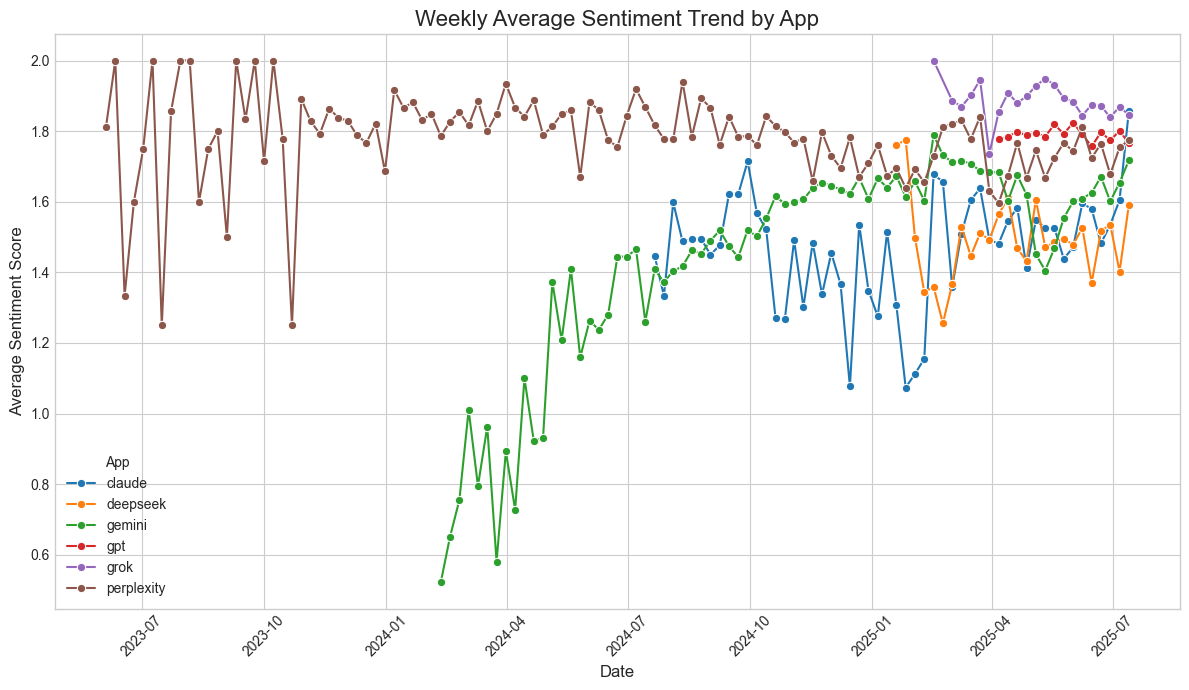

--------------------------------------------------


In [17]:
plot_sentiment_trends(train)

In [18]:
if __name__ == '__main__':
    target_app1 = 'claude' 
    target_app2 = 'deepseek'
    target_app3 = 'gemini'
    target_app4 = 'gpt'
    target_app5 = 'grok'
    target_app6 = 'perplexity'
    lda_visualization1 = perform_topic_modeling(train, app_name=target_app1, num_topics=2)
    lda_visualization2 = perform_topic_modeling(train, app_name=target_app2, num_topics=2)
    lda_visualization3 = perform_topic_modeling(train, app_name=target_app3, num_topics=2)
    lda_visualization4 = perform_topic_modeling(train, app_name=target_app4, num_topics=2)
    lda_visualization5 = perform_topic_modeling(train, app_name=target_app5, num_topics=2)
    lda_visualization6 = perform_topic_modeling(train, app_name=target_app6, num_topics=2)

    

--- Performing Topic Modeling for Negative Reviews of 'claude' ---

Training LDA model with 2 topics...

--- Identified Topics ---
(0, '0.014*"prompt" + 0.013*"number" + 0.012*"phone" + 0.009*"claude" + 0.009*"like" + 0.009*"long" + 0.008*"work" + 0.007*"need" + 0.007*"dont" + 0.007*"error"')
(1, '0.016*"number" + 0.013*"even" + 0.013*"claude" + 0.012*"phone" + 0.012*"cant" + 0.010*"message" + 0.009*"time" + 0.008*"limit" + 0.007*"error" + 0.007*"doesnt"')

--- Generating Visualization ---
--- Performing Topic Modeling for Negative Reviews of 'deepseek' ---

Training LDA model with 2 topics...

--- Identified Topics ---
(0, '0.059*"server" + 0.052*"busy" + 0.024*"time" + 0.022*"always" + 0.015*"please" + 0.012*"slow" + 0.012*"chatgpt" + 0.011*"deepseek" + 0.010*"good" + 0.010*"later"')
(1, '0.019*"cant" + 0.012*"answer" + 0.012*"time" + 0.012*"code" + 0.011*"even" + 0.011*"work" + 0.010*"doesnt" + 0.010*"working" + 0.010*"chat" + 0.010*"sign"')

--- Generating Visualization ---
--- Per

In [19]:
lda_visualization1

PreparedData(topic_coordinates=              x      y  topics  cluster       Freq
topic                                             
1      0.024896  0.042       1        1  64.623999
0     -0.024896 -0.042       2        1  35.376001, topic_info=        Term        Freq       Total Category  logprob  loglift
71    prompt  109.000000  109.000000  Default  30.0000  30.0000
175    voice   32.000000   32.000000  Default  29.0000  29.0000
69      long   79.000000   79.000000  Default  28.0000  28.0000
278     text   33.000000   33.000000  Default  27.0000  27.0000
171     user   43.000000   43.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
19    really   16.290804   40.310050   Topic2  -5.8257   0.1331
260    model   16.017876   38.608200   Topic2  -5.8426   0.1594
136  message   21.530113  126.586945   Topic2  -5.5469  -0.7323
292     even   21.129481  150.140324   Topic2  -5.5657  -0.9218
82      good   17.460202   58.418144   Topic2  -5.7564  -0.1686

[175 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
325       1  0.926733     able
325       2  0.057921     able
208       1  0.844688  account
208       2  0.157484  account
2         1  0.492370     also
...     ...       ...      ...
128       2  0.478229     work
182       1  0.950730   worked
182       2  0.105637   worked
186       1  0.871863    wrong
186       2  0.136229    wrong

[241 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [20]:
lda_visualization2

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.022089  0.069731       1        1  53.266542
1      0.022089 -0.069731       2        1  46.733458, topic_info=        Term         Freq        Total Category  logprob  loglift
40      busy   897.000000   897.000000  Default  30.0000  30.0000
46    server  1080.000000  1080.000000  Default  29.0000  29.0000
39    always   381.000000   381.000000  Default  28.0000  28.0000
16      code   167.000000   167.000000  Default  27.0000  27.0000
381     cant   306.000000   306.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
77      good    69.730216   237.001597   Topic2  -5.3067  -0.4627
36   problem    61.806186   182.384274   Topic2  -5.4274  -0.3214
48      slow    66.739110   264.729046   Topic2  -5.3506  -0.6172
40      busy    66.946007   897.043948   Topic2  -5.3475  -1.8345
206    every    52.382595   113.846659   Topic2  -5.5928  -0.0156

[165 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
229       1  0.129068     able
229       2  0.885041     able
25        1  0.033874  account
25        2  0.965419  account
39        1  0.918919   always
...     ...       ...      ...
56        2  0.747922     work
71        1  0.283575  working
71        2  0.716671  working
24        1  0.922675    worst
24        2  0.080936    worst

[236 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [21]:
lda_visualization3

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.018815  0.059395       1        1  57.836967
0      0.018815 -0.059395       2        1  42.163033, topic_info=            Term         Freq        Total Category  logprob  loglift
26     assistant   965.000000   965.000000  Default  30.0000  30.0000
51          good   419.000000   419.000000  Default  29.0000  29.0000
1           cant   857.000000   857.000000  Default  28.0000  28.0000
78      language   213.000000   213.000000  Default  27.0000  27.0000
30        google  1230.000000  1230.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
133  information    72.847636   123.559838   Topic2  -5.5953   0.3353
75          want    86.396552   376.148739   Topic2  -5.4247  -0.6074
34          like    81.083556   474.953285   Topic2  -5.4882  -0.9041
26     assistant    84.023809   965.194773   Topic2  -5.4525  -1.5776
101         need    76.184179   242.865650   Topic2  -5.5505  -0.2957

[183 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
857       1  0.234348    always
857       2  0.771971    always
326       1  0.438800    answer
326       2  0.561187    answer
81        1  0.349883  anything
...     ...       ...       ...
42        2  0.536000     worst
713       1  0.350683     wrong
713       2  0.646816     wrong
1514      1  0.938330   youtube
1514      2  0.060537   youtube

[271 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [22]:
lda_visualization4

PreparedData(topic_coordinates=             x         y  topics  cluster       Freq
topic                                               
1     -0.02096  0.066165       1        1  52.490318
0      0.02096 -0.066165       2        1  47.509682, topic_info=        Term        Freq       Total Category  logprob  loglift
107     good  415.000000  415.000000  Default  30.0000  30.0000
116     nice  169.000000  169.000000  Default  29.0000  29.0000
226    image  182.000000  182.000000  Default  28.0000  28.0000
94      slow  127.000000  127.000000  Default  27.0000  27.0000
189     much   69.000000   69.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
186    wrong   34.696944   82.285491   Topic2  -5.4305  -0.1193
172     give   37.005836  106.440062   Topic2  -5.3661  -0.3123
222   update   29.319343   57.812521   Topic2  -5.5989   0.0653
205  picture   30.594463   67.402550   Topic2  -5.5564  -0.0456
375     free   27.228631   57.369505   Topic2  -5.6729  -0.0010

[174 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1606      1  0.205645  according
1606      2  0.822580  according
295       1  0.197970     always
295       2  0.791880     always
104       1  0.589585     answer
...     ...       ...        ...
16        2  0.138063    working
17        1  0.134146      worst
17        2  0.855179      worst
186       1  0.583335      wrong
186       2  0.425348      wrong

[238 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [23]:
lda_visualization5

PreparedData(topic_coordinates=              x        y  topics  cluster       Freq
topic                                               
0      0.049009 -0.04146       1        1  56.715712
1     -0.049009  0.04146       2        1  43.284288, topic_info=         Term       Freq      Total Category  logprob  loglift
17    working  71.000000  71.000000  Default  30.0000  30.0000
4        work  61.000000  61.000000  Default  29.0000  29.0000
127     waste  35.000000  35.000000  Default  28.0000  28.0000
16    useless  43.000000  43.000000  Default  27.0000  27.0000
145      slow  22.000000  22.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
237     voice  11.298830  20.980235   Topic2  -5.6546   0.2185
172   chatgpt  13.044772  37.826349   Topic2  -5.5109  -0.2272
28      limit  12.434084  46.764408   Topic2  -5.5588  -0.4873
50   response  11.612029  29.849668   Topic2  -5.6272  -0.1068
67       give  11.656498  41.164115   Topic2  -5.6234  -0.4243

[161 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
308       1  0.202104     able
308       2  0.808417     able
169       1  0.830365  already
18        1  0.413284     also
18        2  0.568265     also
...     ...       ...      ...
3         2  0.361639    worst
89        1  0.157578    wrong
89        2  0.840418    wrong
701       1  0.890111     year
701       2  0.178022     year

[223 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [24]:
lda_visualization6

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.017944  0.056646       1        1  56.107016
1      0.017944 -0.056646       2        1  43.892984, topic_info=       Term        Freq       Total Category  logprob  loglift
180    good  100.000000  100.000000  Default  30.0000  30.0000
97   better   28.000000   28.000000  Default  29.0000  29.0000
0      much   22.000000   22.000000  Default  28.0000  28.0000
130   image   19.000000   19.000000  Default  27.0000  27.0000
145  search   57.000000   57.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
71     free   15.104165   46.494708   Topic2  -5.3881  -0.3010
448    user   12.234955   26.997645   Topic2  -5.5988   0.0320
13     like   14.675019   50.430687   Topic2  -5.4170  -0.4110
113    chat   12.039999   29.356802   Topic2  -5.6149  -0.0679
54    wrong   12.106725   35.626457   Topic2  -5.6093  -0.2559

[165 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
225       1  0.881503     able
225       2  0.160273     able
875       1  0.913931  already
53        1  0.707804   answer
53        2  0.285234   answer
...     ...       ...      ...
73        2  0.106743    worth
310       1  0.803599    would
310       2  0.214293    would
54        1  0.673657    wrong
54        2  0.336828    wrong

[220 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])